<a href="https://colab.research.google.com/github/hsevras/Stamatics-deepflow/blob/main/project1/stamatics_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (412698, 53)
   SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1139246    66000.0     999089     3157         121           3.0      2004   
1  1139248    57000.0     117657       77         121           3.0      1996   
2  1139249    10000.0     434808     7009         121           3.0      2001   
3  1139251    38500.0    1026470      332         121           3.0      2001   
4  1139253    11000.0    1057373    17311         121           3.0      2007   

   MachineHoursCurrentMeter UsageBand         saledate  ...  \
0                      68.0       Low  11/16/2006 0:00  ...   
1                    4640.0       Low   3/26/2004 0:00  ...   
2                    2838.0      High   2/26/2004 0:00  ...   
3                    3486.0      High   5/19/2011 0:00  ...   
4                     722.0    Medium   7/23/2009 0:00  ...   

  Undercarriage_Pad_Width Stick_Length Thumb Pattern_Changer Grouser_Type  \
0                     NaN    

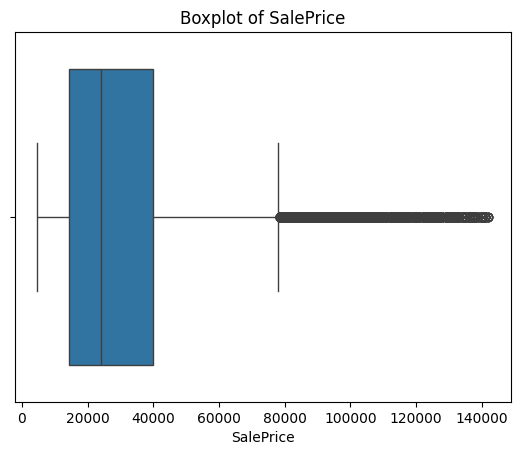

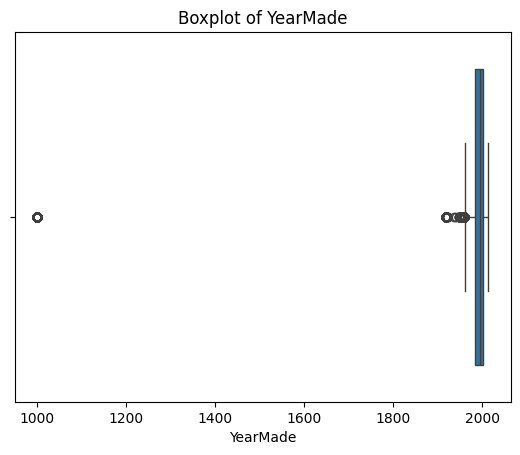

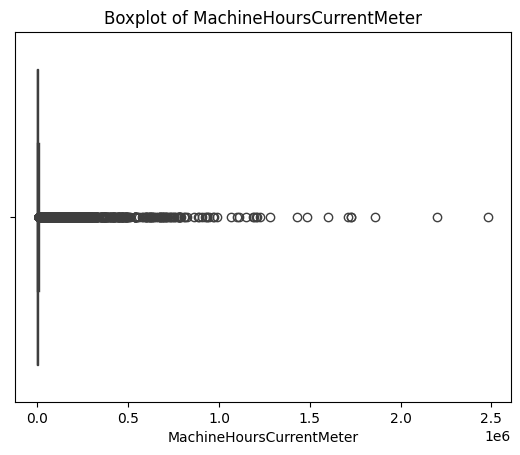

Value counts for ProductGroup:
ProductGroup
TEX    104230
TTT     82582
BL      81401
WL      73216
SSL     45011
MG      26258
Name: count, dtype: int64

Value counts for Drive_System:
Drive_System
NaN                 305611
Two Wheel Drive      47546
Four Wheel Drive     33551
No                   25166
All Wheel Drive        824
Name: count, dtype: int64

Unique SalesID: 412698
Unique MachineID: 348808
Earliest YearMade values:
YearMade
1000    39391
1919      127
1920       17
1937        1
1942        1
1947        1
1948        3
1949        1
1950        8
1951        7
Name: count, dtype: int64
Latest YearMade values:
YearMade
2014        2
2013        1
2012        1
2011       31
2010       58
2009      212
2008     1691
2007     5048
2006    13426
2005    22096
Name: count, dtype: int64
Rows with zero or null MachineHoursCurrentMeter: 339028
saledate type: object
0    11/16/2006 0:00
1     3/26/2004 0:00
2     2/26/2004 0:00
3     5/19/2011 0:00
4     7/23/2009 0:00
Name: sa

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load main dataset with DtypeWarning suppressed
train_df = pd.read_csv('TrainAndValid.csv', low_memory=False)
print('Dataset shape:', train_df.shape)
print(train_df.head())
print('Columns:', train_df.columns.tolist())

# Merge machine metadata if available
machine_appendix = pd.read_csv('Machine_Appendix.csv', low_memory=False)  # Adjust filename if needed
train_df = train_df.merge(machine_appendix, on='MachineID', how='left')

# Remove all _y columns and rename _x columns
y_cols = [col for col in train_df.columns if col.endswith('_y')]
train_df = train_df.drop(y_cols, axis=1)
train_df = train_df.rename(columns={col: col[:-2] for col in train_df.columns if col.endswith('_x')})

# --- Drop columns with >75% missing values ---
missing_pct = train_df.isnull().mean()
high_missing_cols = missing_pct[missing_pct > 0.75].index.tolist()
print("Dropping columns with >75% missing values:", high_missing_cols)
train_df = train_df.drop(high_missing_cols, axis=1)

missing = train_df.isnull().sum().sort_values(ascending=False)
print('Missing values per column:')
print(missing[missing > 0])

# (Optional) Skip the heatmap for speed

print('Data types:')
print(train_df.dtypes)

key_numerical = ['SalePrice', 'YearMade', 'MachineHoursCurrentMeter']
print(train_df[key_numerical].describe())

for col in key_numerical:
    plt.figure()
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

key_categorical = ['UsageBand', 'ProductGroup', 'Drive_System']
for col in key_categorical:
    if col in train_df.columns:
        print(f'Value counts for {col}:')
        print(train_df[col].value_counts(dropna=False))
        print()

print('Unique SalesID:', train_df['SalesID'].nunique())
print('Unique MachineID:', train_df['MachineID'].nunique())

print('Earliest YearMade values:')
print(train_df['YearMade'].value_counts().sort_index().head(10))
print('Latest YearMade values:')
print(train_df['YearMade'].value_counts().sort_index(ascending=False).head(10))

zero_or_null_hours = train_df['MachineHoursCurrentMeter'].isnull() | (train_df['MachineHoursCurrentMeter'] == 0)
print('Rows with zero or null MachineHoursCurrentMeter:', zero_or_null_hours.sum())

print('saledate type:', train_df['saledate'].dtype)
print(train_df['saledate'].head())

if not pd.api.types.is_datetime64_any_dtype(train_df['saledate']):
    train_df['saledate'] = pd.to_datetime(train_df['saledate'], errors='coerce')
    print('Converted saledate to datetime.')
    print(train_df['saledate'].head())

# Extract date features
train_df['sale_year'] = train_df['saledate'].dt.year
train_df['sale_month'] = train_df['saledate'].dt.month
train_df['sale_day'] = train_df['saledate'].dt.day
train_df = train_df.drop('saledate', axis=1)

# Remove duplicates
train_df = train_df.drop_duplicates()

# Identify numerical and categorical columns
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()

# Remove target and ID columns from feature lists
for col in ['SalePrice', 'SalesID', 'MachineID']:
    if col in num_cols:
        num_cols.remove(col)
    if col in cat_cols:
        cat_cols.remove(col)

# Impute missing values
num_imputer = SimpleImputer(strategy='median')
train_df[num_cols] = num_imputer.fit_transform(train_df[num_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
train_df[cat_cols] = cat_imputer.fit_transform(train_df[cat_cols])

# Convert all categorical columns to string type
for col in cat_cols:
    train_df[col] = train_df[col].astype(str)

# One-hot encode only low-cardinality categorical columns
low_card_cols = [col for col in cat_cols if train_df[col].nunique() < 20]
print("Low-cardinality columns to encode:", low_card_cols)
train_df = pd.get_dummies(train_df, columns=low_card_cols, drop_first=True)

# Label encode high-cardinality columns
high_card_cols = [col for col in cat_cols if col not in low_card_cols]
for col in high_card_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))

scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])

X = train_df.drop(['SalePrice', 'SalesID', 'MachineID'], axis=1, errors='ignore')
y = train_df['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Preprocessing complete. Shapes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)

rf_benchmark = pd.read_csv('random_forest_benchmark_test.csv', low_memory=False)
median_benchmark = pd.read_csv('median_benchmark.csv', low_memory=False)



# phase3 from here

!pip install --upgrade lightgbm --quiet

!pip install xgboost --quiet

from lightgbm import LGBMRegressor, early_stopping, log_evaluation


import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


'''
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Train Linear Regression
lr_model.fit(X_train, y_train)

# Train Random Forest
rf_model.fit(X_train, y_train)

# Predictions with Linear Regression
lr_preds = lr_model.predict(X_val)

# Predictions with Random Forest
rf_preds = rf_model.predict(X_val)

lr_rmse = np.sqrt(mean_squared_error(y_val, lr_preds))
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_preds))

lr_rmse = 16669.60   # Linear Regression RMSE from past run
rf_rmse = 7055.41   # Random Forest RMSE from past run

print(f'Linear Regression RMSE: {lr_rmse:.2f}')
print(f'Random Forest RMSE: {rf_rmse:.2f}')







print("\nTraining XGBoost model...")
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    early_stopping_rounds=20  # <-- Move this here
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)


# Predict and evaluate
xgb_preds = xgb_model.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_preds))
print(f'XGBoost Validation RMSE: {xgb_rmse:.2f}')




# Print summary table
print("\nModel Performance Summary:")
print(f"{'Model':<20} {'RMSE (Validation)':>20}")
print(f"{'Linear Regression':<20} {lr_rmse:>20.2f} (previous run)")
print(f"{'Random Forest':<20} {rf_rmse:>20.2f} (previous run)")
print(f"{'XGBoost':<20} {xgb_rmse:>20.2f}")


lgbm = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        early_stopping(stopping_rounds=20),
        log_evaluation(period=50)
    ]
)

lgbm_preds = lgbm.predict(X_val)
lgbm_rmse = np.sqrt(mean_squared_error(y_val, lgbm_preds))
print(f'LightGBM Validation RMSE: {lgbm_rmse:.2f}')
'''
# Previously obtained RMSE results (from past runs)
lr_rmse = 16669.60      # Linear Regression RMSE
rf_rmse = 7055.41       # Random Forest RMSE
xgb_rmse = 7201.89      # XGBoost RMSE
lgbm_rmse = 7326.09     # LightGBM RMSE

print(f'Linear Regression RMSE: {lr_rmse:.2f}')
print(f'Random Forest RMSE: {rf_rmse:.2f}')
print(f'XGBoost RMSE: {xgb_rmse:.2f}')
print(f'LightGBM RMSE: {lgbm_rmse:.2f}')

#the best result are from the random forest model.


#phase4

from sklearn.preprocessing import OrdinalEncoder

# 1. Retrain Random Forest on all available labeled data
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(X, y)

# 2. Load and preprocess the test data
test_df = pd.read_csv('Test.csv', low_memory=False)
test_df = test_df.merge(machine_appendix, on='MachineID', how='left')

# Remove all _y columns and rename _x columns
y_cols_test = [col for col in test_df.columns if col.endswith('_y')]
test_df = test_df.drop(y_cols_test, axis=1)
test_df = test_df.rename(columns={col: col[:-2] for col in test_df.columns if col.endswith('_x')})

# Drop columns with >75% missing values (same as training)
test_df = test_df.drop(high_missing_cols, axis=1)

# Convert 'saledate' to datetime and extract date features
if not pd.api.types.is_datetime64_any_dtype(test_df['saledate']):
    test_df['saledate'] = pd.to_datetime(test_df['saledate'], errors='coerce')
test_df['sale_year'] = test_df['saledate'].dt.year
test_df['sale_month'] = test_df['saledate'].dt.month
test_df['sale_day'] = test_df['saledate'].dt.day
test_df = test_df.drop('saledate', axis=1)

# Remove duplicates
test_df = test_df.drop_duplicates()

# Impute missing values using training imputers
test_df[num_cols] = num_imputer.transform(test_df[num_cols])
test_df[cat_cols] = cat_imputer.transform(test_df[cat_cols])

# Convert all categorical columns to string type
for col in cat_cols:
    test_df[col] = test_df[col].astype(str)

# One-hot encode low-cardinality categorical columns
test_df = pd.get_dummies(test_df, columns=low_card_cols, drop_first=True)

# Ordinal encode high-cardinality columns using training encoder
# Fit OrdinalEncoder on training data if not already done
if 'high_card_oe' not in globals():
    high_card_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    train_df[high_card_cols] = high_card_oe.fit_transform(train_df[high_card_cols])
else:
    train_df[high_card_cols] = high_card_oe.transform(train_df[high_card_cols])

# Transform test using the same encoder
test_df[high_card_cols] = high_card_oe.transform(test_df[high_card_cols])

# Scale numerical features
test_df[num_cols] = scaler.transform(test_df[num_cols])

# Align test features with training features, filling missing columns with 0
X_test = test_df.reindex(columns=X.columns, fill_value=0)

# 3. Generate predictions on test data
test_preds = rf_model.predict(X_test)

# 4. Prepare submission DataFrame
submission = pd.DataFrame({
    'SalesID': test_df['SalesID'],
    'SalePrice': test_preds
})

# 5. Save submission file
submission.to_csv('test_predictions.csv', index=False)
print("Prediction file 'test_predictions.csv' created successfully.")
